In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [32]:
# we will use this dataset for RFM Analysis so we load it here to use cleaned data directly.
df = pd.read_csv('cleaned_data.csv')
cleaned_data = df.copy()
print("🚀 ready for RFM analysis!")
cleaned_data.head()

🚀 ready for RFM analysis!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


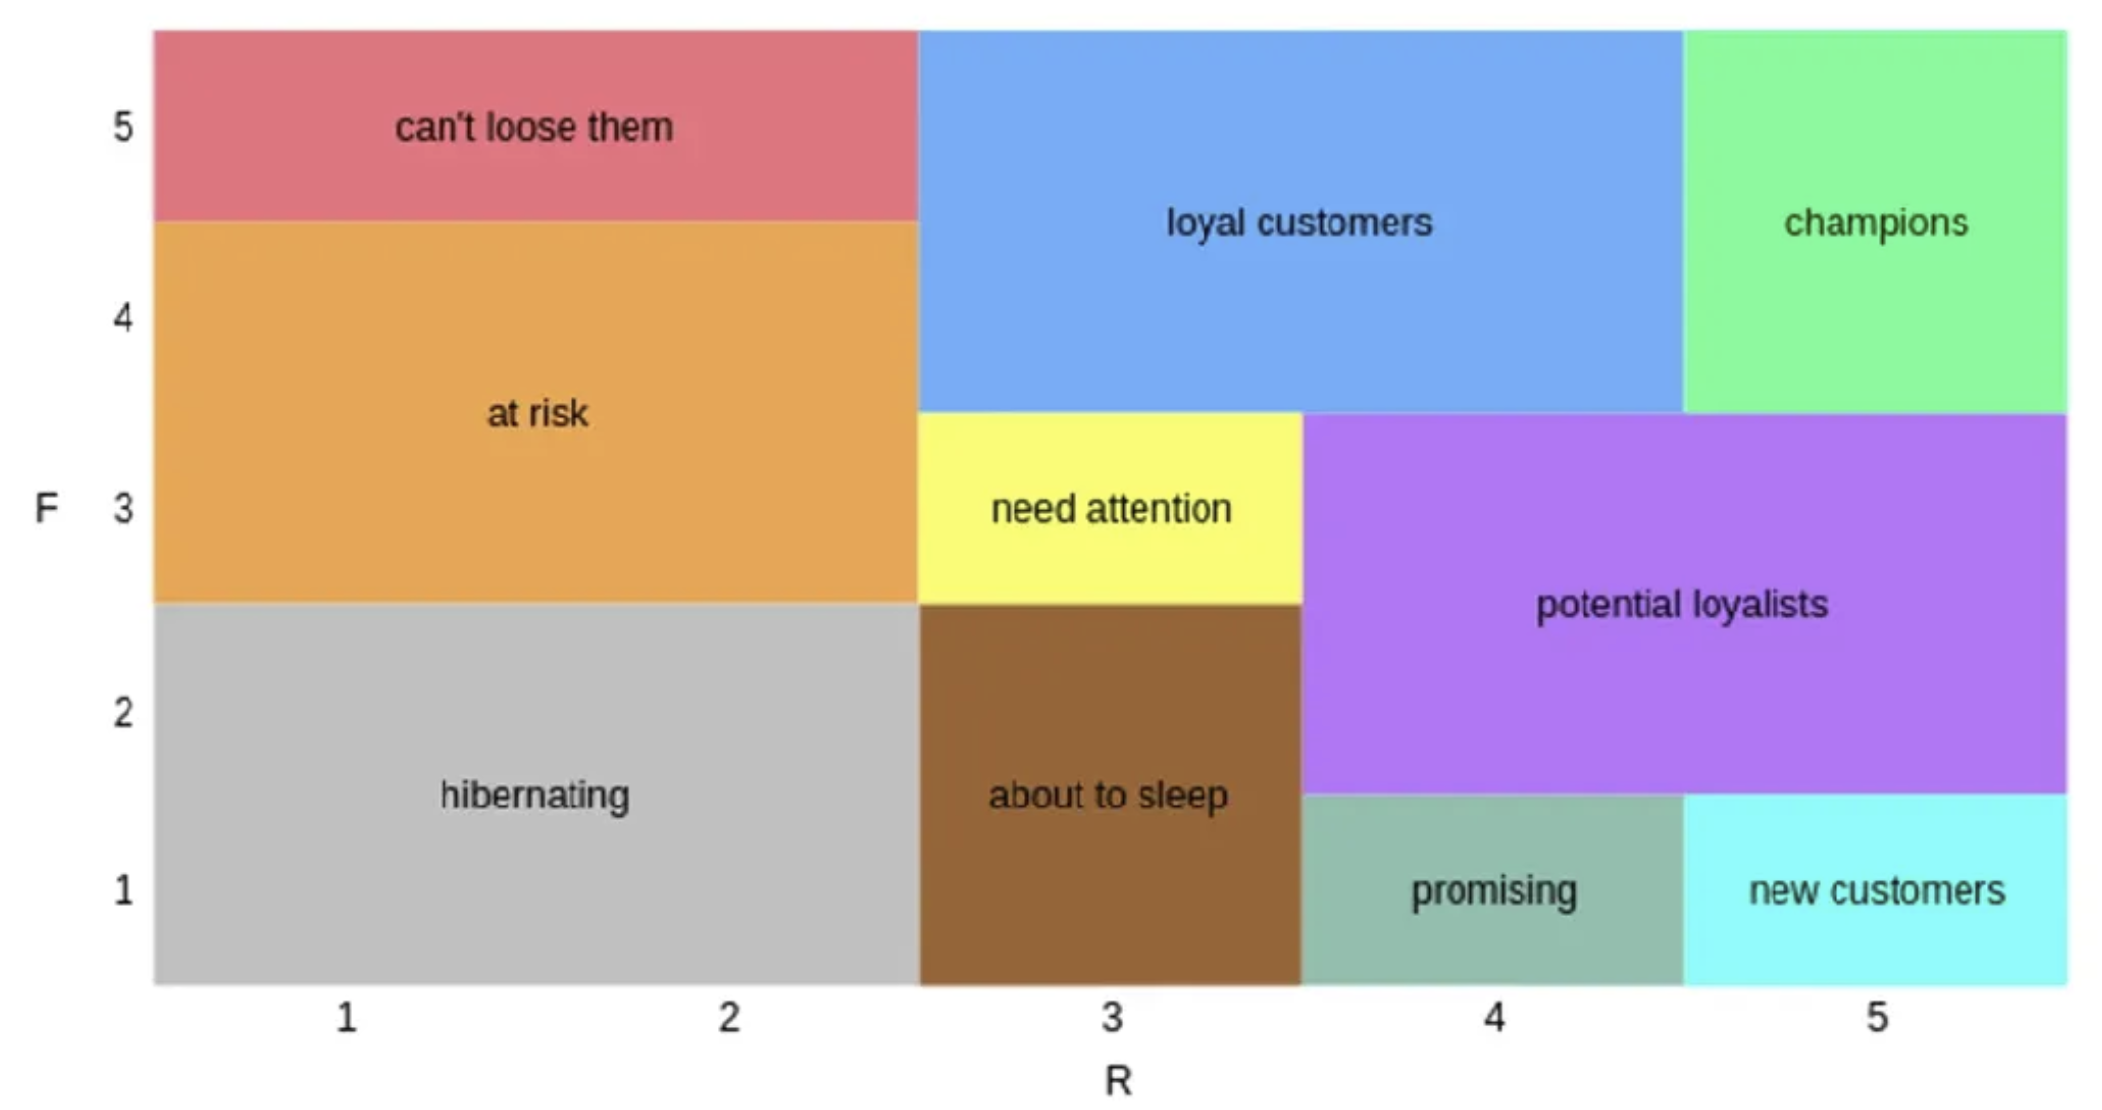

In [ ]:
''' RFM Analysis
Recency: How recently a customer has made a purchase.
Frequency: How often a customer makes a purchase.
Monetary: How much money a customer spends on purchases.
So what is RFM Analysis used for?
RFM Analysis is used to segment customers based on their purchasing behavior. By analyzing Recency, Frequency, and Monetary values, businesses can identify their most valuable customers, target marketing efforts, and improve customer retention strategies.
As a result, the continuity of the currency in the business, the rate of abandonment, and the risk levels can be observed according to the resulting groups.
'''

In [33]:
cleaned_data["InvoiceDate"].max()

'2011-12-09 12:50:00'

In [34]:
# I specify this value to calculate recency values.
today_date = dt.datetime(2011,12,11)

In [ ]:
#unfortunately my cleaned data not yet ready for RFM analysis because there are some 0 or negative values in Quantity and Price columns.
# So we need to clean these values again.
cleaned_data = cleaned_data[(cleaned_data['Quantity'] > 0) & (cleaned_data['Price'] > 0)]


cleaned_data = cleaned_data[~cleaned_data["Invoice"].str.contains("C", na=False)]


df_rfm = cleaned_data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (today_date - x.max()).days,
    "Invoice": "nunique",
    "Total_Price": "sum"
})
#all problems solved, now we can continue RFM analysis.
df_rfm.columns = ['Recency', 'Frequency', 'Monetary']
#we named the columns properly.


df_rfm = df_rfm[df_rfm["Monetary"] > 0]
df_rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [53]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   int64  
 1   Frequency  5878 non-null   int64  
 2   Monetary   5878 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.7 KB


In [54]:
df_rfm.sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary
Customer ID,,,
18102.0,1,145,608821.65
14646.0,2,151,528602.52
14156.0,10,156,313946.37
14911.0,2,398,295972.63
17450.0,9,51,246973.09


In [55]:
# The first five values with the lowest monetary value
df_rfm.sort_values(by = "Monetary", ascending = True).head()

,Recency,Frequency,Monetary
Customer ID,,,
14095.0,723,1,2.95
16738.0,298,1,3.75
13788.0,506,1,3.75
14792.0,64,1,6.20
15913.0,535,1,6.30


In [ ]:
'''Segmentasyon 
In this chapter, I am going to split from recency, frequency, and monetary values to Recency_Score, frequency_score, and monetary_score.'''

In [57]:
#as we have 3 variables, we will create 3 segments.For segmentation.
#we will use qcut function to create segments.
#we rate these segments from 1 to 5 because RFM analysis is based on 5 point scale.
df_rfm["Recency_Score"] = pd.qcut(df_rfm["Recency"], 5, labels = [5, 4, 3, 2, 1]) 
df_rfm["Frequency_Score"] = pd.qcut(df_rfm["Frequency"].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
df_rfm["Monetary_Score"] = pd.qcut(df_rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])

In [58]:
# Last version of df_rfm dataframe.
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346.0,326,12,77556.46,2,5,5
12347.0,3,8,5633.32,5,4,5
12348.0,76,5,2019.40,3,4,4
12349.0,19,4,4428.69,5,3,5
12350.0,311,1,334.40,2,1,2


In [59]:
#now we create RF_Score by combining Recency_Score and Frequency_Score.
df_rfm["RF_Score"] = df_rfm["Recency_Score"].astype(str) + df_rfm["Frequency_Score"].astype(str)

In [60]:
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,25
12347.0,3,8,5633.32,5,4,5,54
12348.0,76,5,2019.40,3,4,4,34
12349.0,19,4,4428.69,5,3,5,53
12350.0,311,1,334.40,2,1,2,21


In [62]:
# Now we will create segments like a RFM table original as i mentioned before.
seg_map = {
    r'[1-2][1-2]' : 'hibernatig',
    r'[1-2][3-4]' : 'at_Risk',
    r'[1-2]5' : 'cant-loose',
    r'3[1-2]' : 'about_to_sleep',
    r'33' : 'need_attention',
    r'[3-4][4-5]' : 'loyal_customers',
    r'41' : 'promising',
    r'51' : 'new_customers',
    r'[4-5][2-3]' : 'potential_loyalists',
    r'5[4-5]' : 'champions'}

In [63]:
# I create segment using RF_Score and segmap.
df_rfm["segment"] = df_rfm["RF_Score"].replace(seg_map, regex = True)

In [64]:
# Last version of df_rfm dataframe.
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,5,5,25,cant-loose
12347.0,3,8,5633.32,5,4,5,54,champions
12348.0,76,5,2019.40,3,4,4,34,loyal_customers
12349.0,19,4,4428.69,5,3,5,53,potential_loyalists
12350.0,311,1,334.40,2,1,2,21,hibernatig


In [65]:
#Rewiew of the segments.
df_rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency                Frequency               \
                           mean     sum count       mean    sum count   
segment                                                                 
about_to_sleep       107.618557   41756   388   1.360825    528   388   
at_Risk              373.942667  280457   750   3.904000   2928   750   
cant-loose           331.802817   23558    71  15.929577   1131    71   
champions              9.250000    7881   852  19.214789  16371   852   
hibernatig           460.012484  700139  1522   1.252300   1906  1522   
loyal_customers       68.306016   78347  1147   9.802964  11244  1147   
need_attention       114.241636   30731   269   3.156134    849   269   
new_customers         11.303571     633    56   1.000000     56    56   
potential_loyalists   26.297335   18750   713   2.589060   1846   713   
promising             39.281818    4321   110   1.000000    110   110   

                         Monetary                     
                             mean          sum count  
segment                                               
about_to_sleep         531.969905   206404.323   388  
at_Risk               1383.596253  1037697.190   750  
cant-loose            8355.677634   593253.112    71  
champions            10795.520581  9197783.535   852  
hibernatig             437.963135   666579.892  1522  
loyal_customers       4199.728592  4817088.695  1147  
need_attention        1283.114015   345157.670   269  
new_customers          356.257857    19950.440    56  
potential_loyalists   1155.427281   823819.651   713  
promising              324.497000    35694.670   110

In [ ]:
''' yeeyyy! We have successfully completed RFM Analysis and customer segmentation based on RFM scores.
'''

In [66]:
# Function to check RF_Score details because see best and worst recency, frequency, and monetary values according to the RF_Score we entered.
def check_RF_Score(rfScore):
    print(f"############ Top five Recency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Recency", ascending = True).head())
    print(f"############ Bottom five Recency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Recency", ascending = False).head())
    
    print(f"############ Top five Frequency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Frequency", ascending = False).head())
    print(f"############ Bottom five Frequency - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Frequency", ascending = True).head())
    print(f"############ Top five Monetary - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Monetary", ascending = False).head())
    print(f"############ Bottom five Monetary - {rfScore} ############")
    print(df_rfm[df_rfm["RF_Score"] == rfScore].sort_values(by = "Monetary", ascending = True).head())

In [73]:
df_rfm[(df_rfm['RF_Score'] == "55") & (df_rfm['Monetary_Score'] == 5)].head()


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12362.0,4,11,5356.23,5,5,5,55,champions
12395.0,20,15,5067.27,5,5,5,55,champions
12417.0,4,20,6816.91,5,5,5,55,champions
12433.0,1,10,20581.26,5,5,5,55,champions
12437.0,2,39,12683.40,5,5,5,55,champions


In [74]:
# Function to check best and worst recency, frequency, and monetary values in the whole dataframe.
def check_rfm_best_and_worst(column):
    if (column == "Recency"):
        print(f"############ Top five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = True).head())
        print(f"############ Bottom five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = False).head())
    else:
        print(f"############ Top five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = False).head())
        print(f"############ Bottom five - {column} ############")
        print(df_rfm.sort_values(by = column, ascending = True).head())

In [75]:
#we can take a look at recency best and worst values.
check_rfm_best_and_worst("Recency")

############ Top five - Recency ############
             Recency  Frequency   Monetary Recency_Score Frequency_Score  \
Customer ID                                                                
12433.0            1         10  20581.260             5               5   
13069.0            1         38   9683.130             5               5   
16705.0            1         42  43515.051             5               5   
12985.0            1          2   1239.380             5               2   
17490.0            1          9   2750.500             5               5   

            Monetary_Score RF_Score              segment  
Customer ID                                               
12433.0                  5       55            champions  
13069.0                  5       55            champions  
16705.0                  5       55            champions  
12985.0                  3       52  potential_loyalists  
17490.0                  4       55            champions  
#########

In [ ]:
'''Oh no, while looking at the chart,
 I see that instead of the champions being in the top rankings,
a potential spy is messing things up. 
This is because even if a customer has a low Monetary score, they can still be in a high segment 
if they make frequent and new purchases. This helps us understand the difference between "loyalty" and
"profitability." However, due to an error on my part during sorting, I need to double-check.'''

In [84]:
print(df_rfm.groupby("segment")["Recency"].mean().sort_values())

segment
champions                9.250000
new_customers           11.303571
potential_loyalists     26.297335
promising               39.281818
loyal_customers         68.306016
about_to_sleep         107.618557
need_attention         114.241636
cant_loose             331.802817
at_Risk                373.942667
hibernating            460.012484
Name: Recency, dtype: float64


In [ ]:
''' i checked and recency is fine.'''

In [87]:
check_rfm_best_and_worst("Frequency")

############ Top five - Frequency ############
             Recency  Frequency   Monetary Recency_Score Frequency_Score  \
Customer ID                                                                
14911.0            2        398  295972.63             5               5   
12748.0            1        336   56599.39             5               5   
17841.0            2        211   70884.07             5               5   
15311.0            1        208  116771.16             5               5   
13089.0            3        203  116737.86             5               5   

            Monetary_Score RF_Score    segment  
Customer ID                                     
14911.0                  5       55  champions  
12748.0                  5       55  champions  
17841.0                  5       55  champions  
15311.0                  5       55  champions  
13089.0                  5       55  champions  
############ Bottom five - Frequency ############
             Recency  Frequ

In [85]:
print(df_rfm.groupby("segment")["Frequency"].mean().sort_values())

segment
new_customers           1.000000
promising               1.000000
hibernating             1.252300
about_to_sleep          1.360825
potential_loyalists     2.589060
need_attention          3.156134
at_Risk                 3.904000
loyal_customers         9.802964
cant_loose             15.929577
champions              19.214789
Name: Frequency, dtype: float64


In [ ]:
''' i checked and frequency is fine.'''

In [88]:
check_rfm_best_and_worst("Monetary")


############ Top five - Monetary ############
             Recency  Frequency   Monetary Recency_Score Frequency_Score  \
Customer ID                                                                
18102.0            1        145  608821.65             5               5   
14646.0            2        151  528602.52             5               5   
14156.0           10        156  313946.37             5               5   
14911.0            2        398  295972.63             5               5   
17450.0            9         51  246973.09             5               5   

            Monetary_Score RF_Score    segment  
Customer ID                                     
18102.0                  5       55  champions  
14646.0                  5       55  champions  
14156.0                  5       55  champions  
14911.0                  5       55  champions  
17450.0                  5       55  champions  
############ Bottom five - Monetary ############
             Recency  Frequen

In [86]:
print(df_rfm.groupby("segment")["Monetary"].mean().sort_values())

segment
promising                324.497000
new_customers            356.257857
hibernating              437.963135
about_to_sleep           531.969905
potential_loyalists     1155.427281
need_attention          1283.114015
at_Risk                 1383.596253
loyal_customers         4199.728592
cant_loose              8355.677634
champions              10795.520581
Name: Monetary, dtype: float64


In [ ]:
''' i checked and monetary is fine.'''

In [89]:
def check_rfm_seg(segment):
    print(f"############ Top five - {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment].sort_values(by = "segment", ascending = False).head())
    print(f"############ Bottom five - {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment].sort_values(by = "segment", ascending = True).head())
    print(f"############ Quantiles with {segment} ############")
    print(df_rfm[df_rfm["segment"] == segment][["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["count", "mean", "sum"]))

In [91]:
check_rfm_seg("hibernating")

############ Top five - hibernating ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12350.0          311          1    334.40             2               1   
16046.0          563          1    235.78             1               1   
16069.0          418          1    457.70             1               1   
16068.0          594          1    122.93             1               1   
16064.0          726          1    111.00             1               1   

            Monetary_Score RF_Score      segment  
Customer ID                                       
12350.0                  2       21  hibernating  
16046.0                  1       11  hibernating  
16069.0                  2       11  hibernating  
16068.0                  1       11  hibernating  
16064.0                  1       11  hibernating  
############ Bottom five - hibernating ############
             Rec

In [92]:
check_rfm_seg("champions")

############ Top five - champions ############
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12347.0            3          8   5633.32             5               4   
16393.0            3         23   5561.66             5               5   
16407.0           13         14   2821.65             5               5   
16411.0           20          4    910.19             5               4   
16422.0           18        109  63651.47             5               5   

            Monetary_Score RF_Score    segment  
Customer ID                                     
12347.0                  5       54  champions  
16393.0                  5       55  champions  
16407.0                  4       55  champions  
16411.0                  3       54  champions  
16422.0                  5       55  champions  
############ Bottom five - champions ############
             Recency  Frequency  M

In [93]:
# In this code, I create copy to df_rfm because I am going to use it for visualization.
df_rfmv2 = df_rfm.copy()
df_rfmv2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Recency          5878 non-null   int64   
 1   Frequency        5878 non-null   int64   
 2   Monetary         5878 non-null   float64 
 3   Recency_Score    5878 non-null   category
 4   Frequency_Score  5878 non-null   category
 5   Monetary_Score   5878 non-null   category
 6   RF_Score         5878 non-null   object  
 7   segment          5878 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 293.4+ KB


In [94]:
# I change the types of recency_score, frequency_score, and monetary_score to the integer type.
df_rfmv2["Recency_Score"] = df_rfmv2["Recency_Score"].astype(int)
df_rfmv2["Frequency_Score"] = df_rfmv2["Frequency_Score"].astype(int)
df_rfmv2["Monetary_Score"] = df_rfmv2["Monetary_Score"].astype(int)
df_rfmv2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Recency          5878 non-null   int64  
 1   Frequency        5878 non-null   int64  
 2   Monetary         5878 non-null   float64
 3   Recency_Score    5878 non-null   int64  
 4   Frequency_Score  5878 non-null   int64  
 5   Monetary_Score   5878 non-null   int64  
 6   RF_Score         5878 non-null   object 
 7   segment          5878 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 413.3+ KB


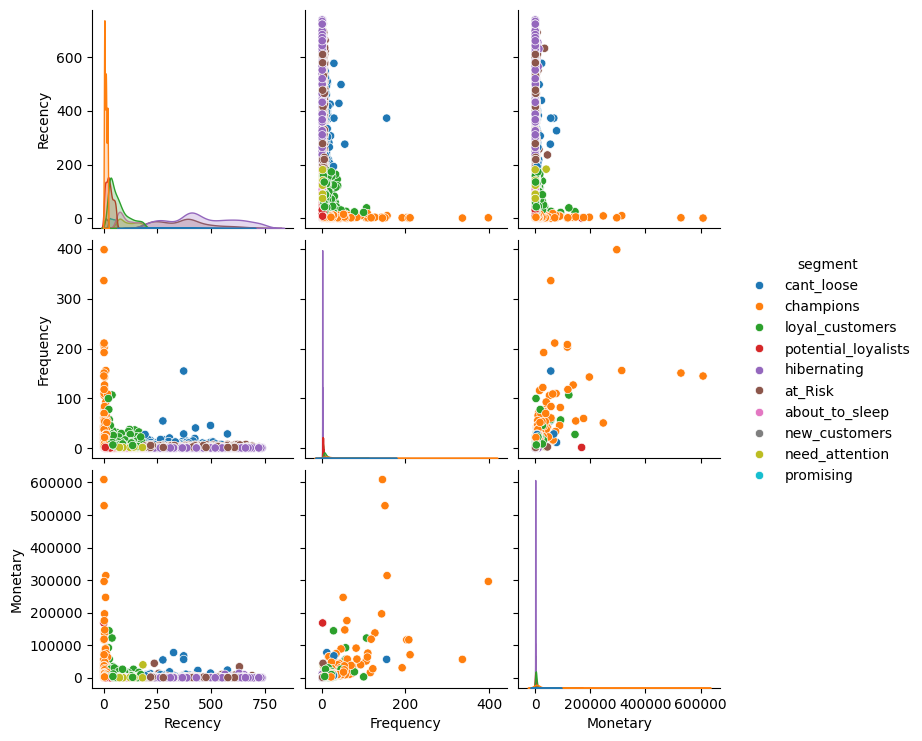

In [95]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(df_rfm, hue = "segment")

In [ ]:
'''"The metrics obtained from this RFM analysis form the basic input (feature) set for CLTV (BG-NBD & Gamma-Gamma) models,"
" which will be used to forecast the company's future cash flow."'''

In [96]:
# we save the rfm analysis results to use in CLTV analysis.
cleaned_data.to_csv("cleaned_data2.csv", index=False)